## Previous trials Antispoofing Module

This notebook shows our initial attempts, which led us to decide to use MobileNet trained on a combination of balanced datasets from MSU-MFSD Photos and NUAA, as the final model for antispoofing. We started by taking the pre-trained MobileNet_v2 and modifying the last layer for binary classification between real and spoofed images.

Several combinations of tests were then carried out. Initially, we trained the model solely on the NUAA dataset and tested it on unseen portions of NUAA data, achieving excellent, nearly perfect performance. At this point, we wanted to evaluate the model's ability to generalize to the MSU dataset, which differs significantly in terms of image type, lighting and other conditions. As expected, the performance degraded, likely due to the different nature of the images, including the use of different devices to capture them.

We then reversed the process, first training MobileNet on MSU and testing it on unseen MSU data, where the results were again nearly flawless. However, when evaluating the model on NUAA, the performance dropped significantly, similar to the previous case.

At this stage, we decided to incorporate the Local Binary Pattern (LBP) technique as a preprocessing step for the images before training MobileNet, hypothesizing that LBP could help capture texture variations between spoofed images and real faces. We trained MobileNet with LBP preprocessing and tested it on unseen NUAA instances, once again achieving perfect performance. When tested on MSU, the performance improved compared to the previous tests but still remained significantly lower than when tested on different portions of the same dataset.

We applied the same process by training MobileNet with LBP on MSU and testing it on MSU portions, obtaining excellent results again. However, when tested on NUAA, although there was a notable improvement, the performance still lagged far behind the evaluation on MSU.

At this point, noticing the discrepancy in results, we decided to train the MobileNetv2 model not on individual datasets, but on a balanced combination of both datasets. This way, the model was exposed to a wider range of variations during training. We then tested it on a portion of data containing instances from both datasets, which had not been used during training. As a result, the model is now able to generalize better across a greater number of variations from both datasets. You can find the full training and evaluation on the combined dataset in the file "Antispoofing_module_training_and_evaluation.ipynb".

## Dataset upload and image preprocessing

In [2]:
import os
import numpy as np
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import models, transforms
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from skimage.feature import local_binary_pattern
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
import warnings
from torchsummary import summary

In [3]:
warnings.filterwarnings("ignore")  # Suppress all warnings
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [4]:
# Load the saved NumPy arrays for the NUAA dataset (images, labels, and spoof status)
X_nuaa = np.load(r"C:\Users\Asus\Desktop\Biometric Systems\Numpy_arrays\X_nuaa.npy")
y_nuaa = np.load(r"C:\Users\Asus\Desktop\Biometric Systems\Numpy_arrays\y_nuaa.npy")
S_nuaa = np.load(r"C:\Users\Asus\Desktop\Biometric Systems\Numpy_arrays\S_nuaa.npy")

print("Shape of X_nuaa:", X_nuaa.shape)
print("Shape of y_nuaa:", y_nuaa.shape)
print("Shape of S_nuaa:", S_nuaa.shape)

Shape of X_nuaa: (12547, 224, 224, 3)
Shape of y_nuaa: (12547,)
Shape of S_nuaa: (12547,)


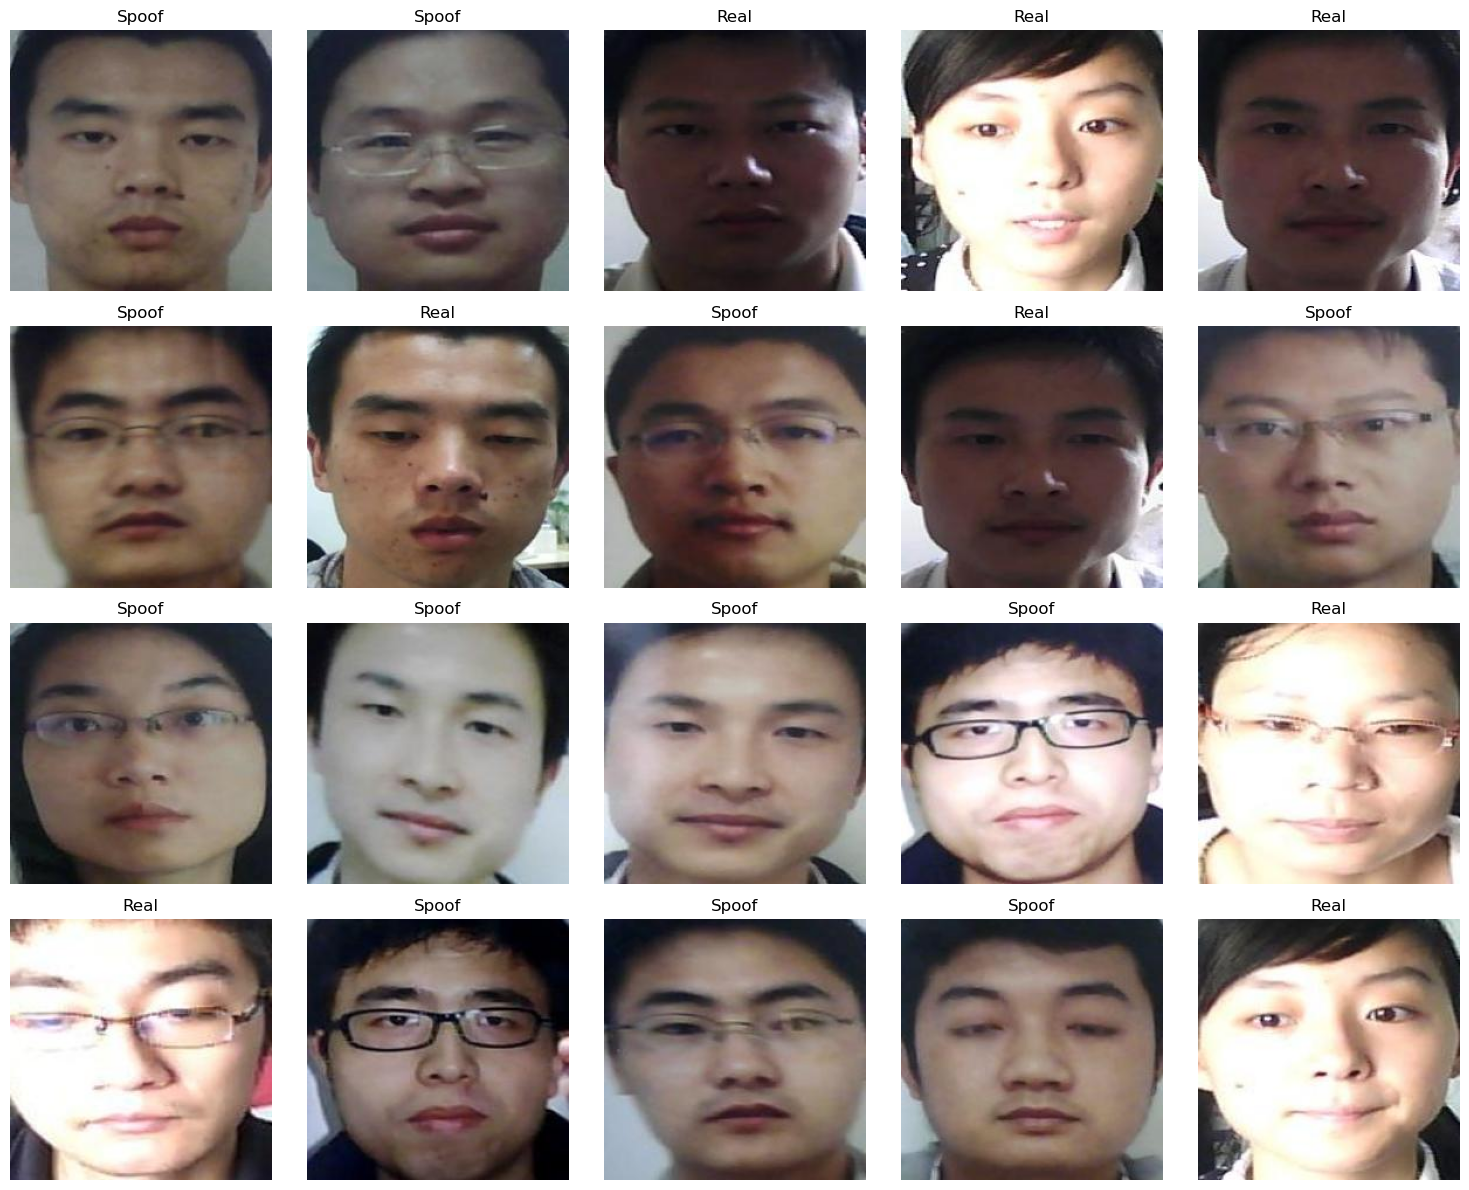

In [5]:
# Select 20 random images from the dataset for visualization
num_images = 20
random_indices = np.random.choice(X_nuaa.shape[0], num_images, replace=False)

# Create a grid of 4x5 subplots for displaying the images
fig, axes = plt.subplots(4, 5, figsize=(15, 12))

# Loop over the randomly selected images and plot each one
for i, ax in enumerate(axes.flat):
    idx = random_indices[i]

    # Convert the image from BGR to RGB for visualization
    image_rgb = X_nuaa[idx][..., ::-1]

    # Display the image on the current subplot
    ax.imshow(image_rgb)
    # Determine if the image is 'Spoof' or 'Real' based on the spoof status
    spoof_status = "Spoof" if S_nuaa[idx] == 1 else "Real"
    # Set the title of the image as either 'Spoof' or 'Real'
    ax.set_title(f"{spoof_status}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [6]:
# Define parameters for Local Binary Pattern (LBP)
radius = 1  # Radius for LBP
n_points = 8 * radius  # Number of sampling points around each pixel

# Function to apply LBP to a single color channel (R, G or B)
def apply_lbp(channel):
    return local_binary_pattern(channel, n_points, radius, method='uniform')

# Function to apply LBP to an entire image by processing each color channel
def lbp_transform(image):
    # Apply LBP to the red, green, and blue channels
    lbp_r = apply_lbp(image[:, :, 0])
    lbp_g = apply_lbp(image[:, :, 1])
    lbp_b = apply_lbp(image[:, :, 2])
    # Normalize each channel to the range [0, 255] for proper visualization
    lbp_r_normalized = cv2.normalize(lbp_r, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX).astype(np.uint8)
    lbp_g_normalized = cv2.normalize(lbp_g, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX).astype(np.uint8)
    lbp_b_normalized = cv2.normalize(lbp_b, None, alpha=0, beta=255, norm_type=cv2.NORM_MINMAX).astype(np.uint8)
    # Merge the normalized LBP channels back into an RGB image
    lbp_color = cv2.merge((lbp_r_normalized, lbp_g_normalized, lbp_b_normalized))
    return lbp_color

In [7]:
class ImageDataset(Dataset):
    def __init__(self, images, labels, transform=None, additional_preprocessing=None):
        self.images = images
        self.labels = labels
        self.transform = transform
        self.additional_preprocessing = additional_preprocessing

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx]
        label = self.labels[idx]
        # Apply LBP preprocessing if specified
        if self.additional_preprocessing == 'lbp':
            image = lbp_transform(image)

        if self.transform:
            image = self.transform(image)
        return image, label

In [8]:
# Set parameters for image size, epochs, batch size, and learning rate
IMG_SIZE = (224, 224)
EPOCHS = 10
BATCH_SIZE = 32
LEARNING_RATE = 0.0001

# Define the image transformations to apply to each image before feeding into the model
transform = transforms.Compose([
    transforms.ToPILImage(), # Convert image to PIL format
    transforms.Resize(IMG_SIZE), # Resize the image to the required input size
    transforms.ToTensor(), # Convert image to tensor format
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) # Normalize based on ImageNet statistics
])

# First split: training set and temporary set (which will be further split into validation and test sets)
X_train_nuaa, X_temp_nuaa, S_train_nuaa, S_temp_nuaa = train_test_split(X_nuaa, S_nuaa, test_size=0.2, random_state=42)

# Second split: validation set and test set
X_val_nuaa, X_test_nuaa, S_val_nuaa, S_test_nuaa = train_test_split(X_temp_nuaa, S_temp_nuaa, test_size=0.5, random_state=42)

In [9]:
print("X_train_nuaa shape:", X_train_nuaa.shape)
print("S_train_nuaa shape:", S_train_nuaa.shape)
print("X_val_nuaa shape:", X_val_nuaa.shape)
print("S_val_nuaa shape:", S_val_nuaa.shape)
print("X_test_nuaa shape:", X_test_nuaa.shape)
print("S_test_nuaa shape:", S_test_nuaa.shape)

X_train_nuaa shape: (10037, 224, 224, 3)
S_train_nuaa shape: (10037,)
X_val_nuaa shape: (1255, 224, 224, 3)
S_val_nuaa shape: (1255,)
X_test_nuaa shape: (1255, 224, 224, 3)
S_test_nuaa shape: (1255,)


In [10]:
# Load the MSU dataset
X_msu = np.load(r"C:\Users\Asus\Desktop\Biometric Systems\Numpy_arrays\X_msu.npy")
y_msu = np.load(r"C:\Users\Asus\Desktop\Biometric Systems\Numpy_arrays\y_msu.npy")
S_msu = np.load(r"C:\Users\Asus\Desktop\Biometric Systems\Numpy_arrays\S_msu.npy")

print("Shape of X_msu:", X_msu.shape)
print("Shape of y_msu:", y_msu.shape)
print("Shape of S_msu:", S_msu.shape)

Shape of X_msu: (77671, 224, 224, 3)
Shape of y_msu: (77671,)
Shape of S_msu: (77671,)


In [11]:
# Find the indices of real and spoof images in the MSU dataset
real_indices = np.where(S_msu == 0)[0]
attack_indices = np.where(S_msu == 1)[0]

# Randomly select 19,000 real and 19,000 attack images for balanced data
np.random.seed(42)
selected_real_indices = np.random.choice(real_indices, 19000, replace=False)
selected_attack_indices = np.random.choice(attack_indices, 19000, replace=False)

# Combine and shuffle the selected indices to mix real and spoof images
selected_indices = np.concatenate((selected_real_indices, selected_attack_indices))

# Shuffle the indices to mix real and attack images
np.random.shuffle(selected_indices)

# Create new arrays with these selected indices
X_msu = X_msu[selected_indices]
y_msu = y_msu[selected_indices]
S_msu = S_msu[selected_indices]

print("Shape of X_msu:", X_msu.shape)
print("Shape of y_msu:", y_msu.shape)
print("Shape of S_msu:", S_msu.shape)

Shape of X_msu: (38000, 224, 224, 3)
Shape of y_msu: (38000,)
Shape of S_msu: (38000,)


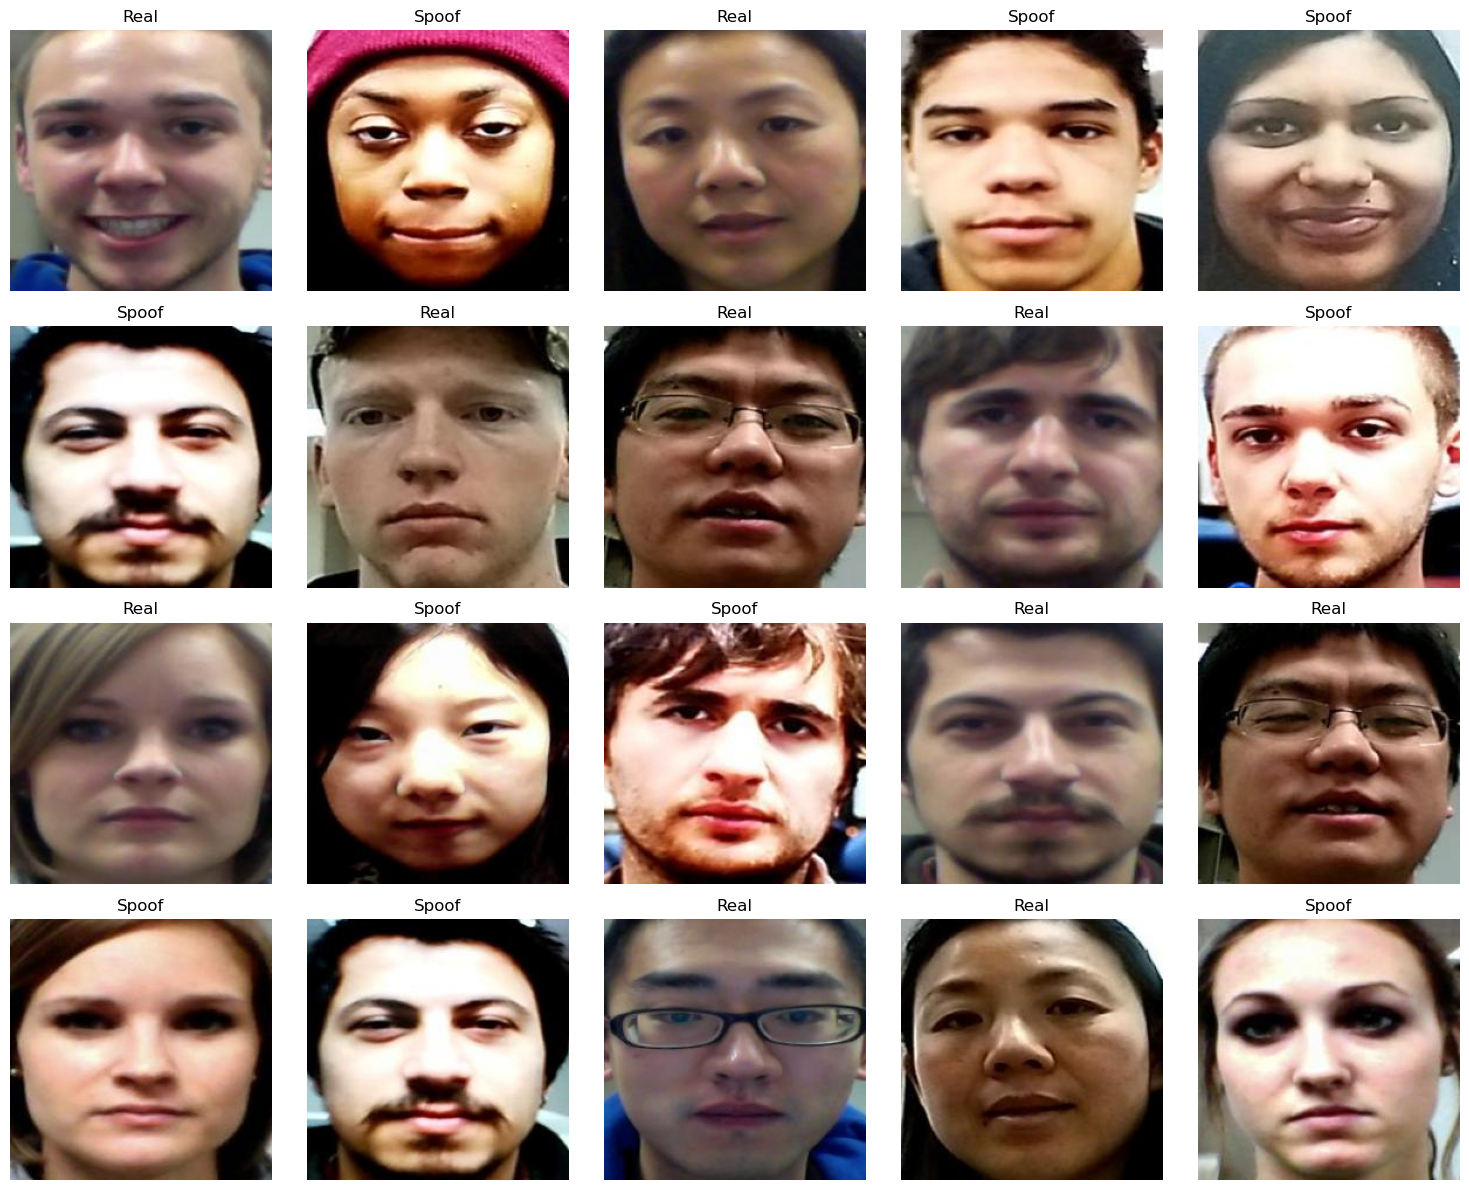

In [12]:
# Select 20 random images from the dataset for visualization
num_images = 20
random_indices = np.random.choice(X_msu.shape[0], num_images, replace=False)

# Create a grid of 4x5 subplots for displaying the images
fig, axes = plt.subplots(4, 5, figsize=(15, 12))

for i, ax in enumerate(axes.flat):
    idx = random_indices[i]

    # Convert the image from BGR to RGB for visualization
    image_rgb = X_msu[idx][..., ::-1]
    
    ax.imshow(image_rgb)
    # Determine if the image is 'Spoof' or 'Real' based on the spoof status
    spoof_status = "Spoof" if S_msu[idx] == 1 else "Real"
    ax.set_title(f"{spoof_status}")
    ax.axis('off')

plt.tight_layout()
plt.show()

In [13]:
# First split: training set and temporary set (which will be further split into validation and test sets)
X_train_msu, X_temp_msu, S_train_msu, S_temp_msu = train_test_split(X_msu, S_msu, test_size=0.2, random_state=42)

# Second split: validation set and test set
X_val_msu, X_test_msu, S_val_msu, S_test_msu = train_test_split(X_temp_msu, S_temp_msu, test_size=0.5, random_state=42)

In [14]:
print("X_train_msu shape:", X_train_msu.shape)
print("S_train_msu shape:", S_train_msu.shape)
print("X_val_msu shape:", X_val_msu.shape)
print("S_val_msu shape:", S_val_msu.shape)
print("X_test_msu shape:", X_test_msu.shape)
print("S_test_msu shape:", S_test_msu.shape)

X_train_msu shape: (30400, 224, 224, 3)
S_train_msu shape: (30400,)
X_val_msu shape: (3800, 224, 224, 3)
S_val_msu shape: (3800,)
X_test_msu shape: (3800, 224, 224, 3)
S_test_msu shape: (3800,)


## Utils

In [16]:
def save_model(model, model_name_pth):
    torch.save(model.state_dict(), model_name_pth)

## MobileNet Model Training and Evaluation

In [18]:
# Create datasets for NUAA (training and validation sets)
train_dataset_nuaa = ImageDataset(X_train_nuaa, S_train_nuaa, transform=transform, additional_preprocessing=None)
val_dataset_nuaa = ImageDataset(X_val_nuaa, S_val_nuaa, transform=transform, additional_preprocessing=None)

In [19]:
# Create data loaders for NUAA (training and validation)
train_loader_nuaa = DataLoader(train_dataset_nuaa, batch_size=BATCH_SIZE, shuffle=True)
val_loader_nuaa = DataLoader(val_dataset_nuaa, batch_size=BATCH_SIZE, shuffle=False)

In [20]:
# Create datasets for MSU (training and validation sets)
train_dataset_msu = ImageDataset(X_train_msu, S_train_msu, transform=transform, additional_preprocessing=None)
val_dataset_msu = ImageDataset(X_val_msu, S_val_msu, transform=transform, additional_preprocessing=None)

In [21]:
# Create data loaders for MSU (training and validation)
train_loader_msu = DataLoader(train_dataset_msu, batch_size=BATCH_SIZE, shuffle=True)
val_loader_msu = DataLoader(val_dataset_msu, batch_size=BATCH_SIZE, shuffle=False)

In [22]:
# Function to load and modify the pre-trained MobileNet model for binary classification
def load_mobilenet(learning_rate, device):
    model = models.mobilenet_v2(pretrained=True)

    # Modify the last layer for binary classification
    model.classifier[1] = nn.Linear(model.classifier[1].in_features, 1)
    model = model.to(device)
    
   # Set loss function (binary cross-entropy) and optimizer (Adam)
    criterion = nn.BCEWithLogitsLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    return model, criterion, optimizer

In [23]:
# Function to train and evaluate the MobileNet model
def train_and_eval_mobilenet(model, train_loader, val_loader, criterion, optimizer, epochs, device):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Loop through epochs
    for epoch in range(epochs):
        model.train() # Set model to training mode
        running_loss = 0.0
        correct = 0
        total = 0

        # Training loop
        for images, labels in train_loader:
            images = images.to(device)
            labels = labels.float().unsqueeze(1).to(device)
    
            optimizer.zero_grad() # Zero gradients
            outputs = model(images)
            loss = criterion(outputs, labels) # Calculate loss
            loss.backward() # Backpropagate
            optimizer.step() # Update model weights
    
            running_loss += loss.item()
            predicted = (torch.sigmoid(outputs) > 0.5).float() # Apply the threshold the outputs
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        # Calculate training accuracy and loss
        train_loss = running_loss / len(train_loader)
        train_accuracy = 100 * correct / total
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)

        # Evaluate the model on the validation set
        model.eval() # Set model to evaluation mode
        val_loss = 0.0
        correct = 0
        total = 0
    
        with torch.no_grad(): # Disable gradient computation during evaluation
            for images, labels in val_loader:
                images = images.to(device)
                labels = labels.float().unsqueeze(1).to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
    
                val_loss += loss.item()
                predicted = (torch.sigmoid(outputs) > 0.5).float()
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        # Calculate validation accuracy and loss
        val_loss /= len(val_loader)
        val_accuracy = 100 * correct / total
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)
    
        print(f'Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.2f}%, '
              f'Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.2f}%')
    
    return model, train_losses, val_losses, train_accuracies, val_accuracies

In [24]:
def plot_training_curves(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = len(train_losses)
    
    plt.figure(figsize=(12, 5))
    
    plt.subplot(1, 2, 1)
    plt.plot(range(1, epochs+1), train_losses, label='Train Loss')
    plt.plot(range(1, epochs+1), val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(range(1, epochs+1), train_accuracies, label='Train Accuracy')
    plt.plot(range(1, epochs+1), val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()
    
    plt.show()

In [25]:
# Evaluation of the trained model on the test set
def test_model(loaded_model, test_loader):
    threshold = 0.5 # Set a threshold for binary classification (spoof vs real)
    results = [] # Initialize a list to store evaluation results

    # Disable gradient calculation during testing for performance improvement
    with torch.no_grad():
        corrects = 0 # Initialize counter for correct predictions
        total = 0 # Initialize counter for total predictions
        TP = FP = TN = FN = 0 # Initialize counters for True Positives, False Positives, True Negatives, and False Negatives

        # Loop through batches of images and labels in the test set
        for images, labels in test_loader:
            images, labels = images.to(device), labels.float().to(device).unsqueeze(1)
    
            outputs = loaded_model(images) # Get model predictions for the images
            preds = torch.sigmoid(outputs) > threshold # Apply a sigmoid function to convert model outputs to probabilities, and classify based on the threshold
    
            TP += ((preds == 0) & (labels == 0)).sum().item() # True Positives: cases where the model predicted 0 (positive/real) and the actual label is also 0 (real)                    
            TN += ((preds == 1) & (labels == 1)).sum().item() # True Negatives: cases where the model predicted 1 (negative/spoof) and the actual label is also 1 (spoof)
            FP += ((preds == 0) & (labels == 1)).sum().item() # False Positives: cases where the model predicted 0 (positive/real), but the actual label is 1 (spoof)
            FN += ((preds == 1) & (labels == 0)).sum().item() # False Negatives: cases where the model predicted 1 (negatives/spoof), but the actual label is 0 (real)
    
            corrects += (preds == labels).sum().item() # Count the number of correct predictions
            total += labels.size(0) # Keep track of the total number of predictions

        APCER = FP / (FP + TN) if (FP + TN) > 0 else 0 # Calculate APCER (Attack Presentation Classification Error Rate): the proportion of spoof images incorrectly classified as real
        BPCER = FN / (FN + TP) if (FN + TP) > 0 else 0 # Calculate BPCER (Bona Fide Presentation Classification Error Rate): the proportion of real images incorrectly classified as spoof
        ACER = (APCER + BPCER) / 2 # Calculate ACER (Average Classification Error Rate): the average of APCER and BPCER
        accuracy = corrects / total # Calculate accuracy: the proportion of correct predictions over the total number of predictions
        recall = TP / (TP + FN) if (TP + FN) > 0 else 0 # Calculate recall (True Positive Rate): the proportion of real images correctly classified
        precision = TP / (TP + FP) if (TP + FP) > 0 else 0 # Calculate precision: the proportion of predicted real images that are actually real
        f1_score = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0 # Calculate F1-Score: the harmonic mean of precision and recall, used to balance the two metrics
    
        results.append({
            'accuracy': accuracy,
            'APCER': APCER,
            'BPCER': BPCER,
            'ACER': ACER,
            'precision': precision,
            'recall': recall,
            'f1_score': f1_score,
            'TP': TP,
            'TN': TN,
            'FP': FP,
            'FN': FN
        })
    
        print(f'APCER: {APCER:.2f}, BPCER: {BPCER:.2f}, ACER: {ACER:.2f}')
        print(f'Accuracy: {accuracy:.2f}, Precision: {precision:.2f}, Recall: {recall:.2f}, F1-Score: {f1_score:.2f}')
        
    return loaded_model, results, TP, TN, FP, FN

In [26]:
# Function to plot a confusion matrix based on TP (True Positives), TN (True Negatives), FP (False Positives), FN (False Negatives)
def plot_confusion_matrix(TP, TN, FP, FN):
    cm = np.array([[TN, FP], [FN, TP]])
    labels = ['Real', 'Spoof'] # Labels for the two classes: 'Real' (positive) and 'Spoof' (negative)
    
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()

In [27]:
# Load the MobileNet model
model_nuaa, criterion_nuaa, optimizer_nuaa = load_mobilenet(LEARNING_RATE, device)

In [28]:
summary(model_nuaa, input_size=(3, 224, 224), verbose=0)

Layer (type:depth-idx)                             Param #
├─Sequential: 1-1                                  --
|    └─Conv2dNormActivation: 2-1                   --
|    |    └─Conv2d: 3-1                            864
|    |    └─BatchNorm2d: 3-2                       64
|    |    └─ReLU6: 3-3                             --
|    └─InvertedResidual: 2-2                       --
|    |    └─Sequential: 3-4                        896
|    └─InvertedResidual: 2-3                       --
|    |    └─Sequential: 3-5                        5,136
|    └─InvertedResidual: 2-4                       --
|    |    └─Sequential: 3-6                        8,832
|    └─InvertedResidual: 2-5                       --
|    |    └─Sequential: 3-7                        10,000
|    └─InvertedResidual: 2-6                       --
|    |    └─Sequential: 3-8                        14,848
|    └─InvertedResidual: 2-7                       --
|    |    └─Sequential: 3-9                        14,848
|  

In [29]:
# Train and evaluate the model on the NUAA dataset using the training and validation loaders
model_nuaa, train_losses_nuaa, val_losses_nuaa, train_accuracies_nuaa, val_accuracies_nuaa = train_and_eval_mobilenet(model_nuaa, train_loader_nuaa, val_loader_nuaa, criterion_nuaa, optimizer_nuaa, EPOCHS, device)

Epoch 1/10, Train Loss: 0.0219, Train Accuracy: 99.42%, Val Loss: 0.0005, Val Accuracy: 100.00%
Epoch 2/10, Train Loss: 0.0024, Train Accuracy: 99.95%, Val Loss: 0.0001, Val Accuracy: 100.00%
Epoch 3/10, Train Loss: 0.0004, Train Accuracy: 100.00%, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 4/10, Train Loss: 0.0002, Train Accuracy: 100.00%, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 5/10, Train Loss: 0.0001, Train Accuracy: 100.00%, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 6/10, Train Loss: 0.0001, Train Accuracy: 100.00%, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 7/10, Train Loss: 0.0026, Train Accuracy: 99.90%, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 8/10, Train Loss: 0.0001, Train Accuracy: 100.00%, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 9/10, Train Loss: 0.0001, Train Accuracy: 100.00%, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 10/10, Train Loss: 0.0002, Train Accuracy: 100.00%, Val Loss: 0.0000, Val Accuracy: 100.00%


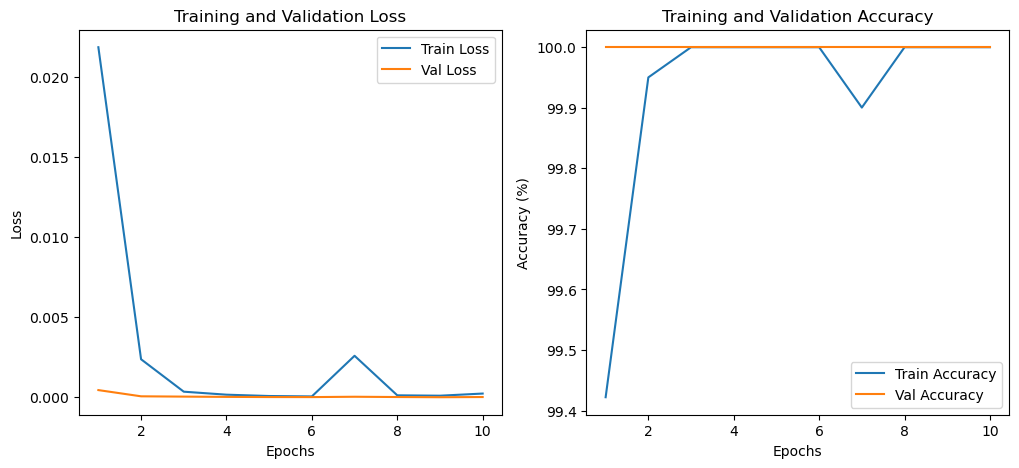

In [30]:
# Plot training curves (losses and accuracies) for the NUAA dataset
plot_training_curves(train_losses_nuaa, val_losses_nuaa, train_accuracies_nuaa, val_accuracies_nuaa)

In [31]:
# Create a test dataset and loader for NUAA
test_dataset_nuaa = ImageDataset(X_test_nuaa, S_test_nuaa, transform=transform, additional_preprocessing=None)
test_loader_nuaa = DataLoader(test_dataset_nuaa, batch_size=BATCH_SIZE, shuffle=False)

In [32]:
# Create a test dataset and loader for MSU
test_dataset_msu = ImageDataset(X_test_msu, S_test_msu, transform=transform, additional_preprocessing=None)
test_loader_msu = DataLoader(test_dataset_msu, batch_size=BATCH_SIZE, shuffle=False)

In [33]:
# Test the model trained on NUAA using the unseen test data of NUAA
loaded_model_nuaa, results_nuaa_nuaa, TP_nuaa_nuaa, TN_nuaa_nuaa, FP_nuaa_nuaa, FN_nuaa_nuaa = test_model(model_nuaa, test_loader_nuaa)

APCER: 0.00, BPCER: 0.00, ACER: 0.00
Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-Score: 1.00


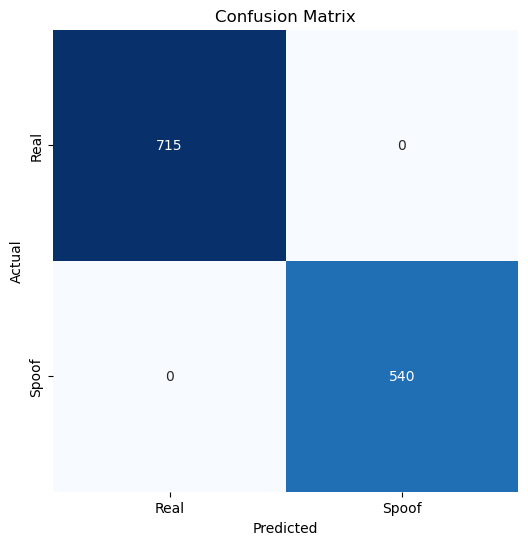

In [34]:
# Plot the confusion matrix for the NUAA test results
plot_confusion_matrix(TP=results_nuaa_nuaa[0]['TP'], TN=results_nuaa_nuaa[0]['TN'], FP=results_nuaa_nuaa[0]['FP'], FN=results_nuaa_nuaa[0]['FN'])

In [35]:
# Test the model trained on NUAA using the test set of MSU
loaded_model_nuaa, results_nuaa_msu, TP_nuaa_msu, TN_nuaa_msu, FP_nuaa_msu, FN_nuaa_msu = test_model(model_nuaa, test_loader_msu)

APCER: 0.66, BPCER: 0.38, ACER: 0.52
Accuracy: 0.48, Precision: 0.48, Recall: 0.62, F1-Score: 0.54


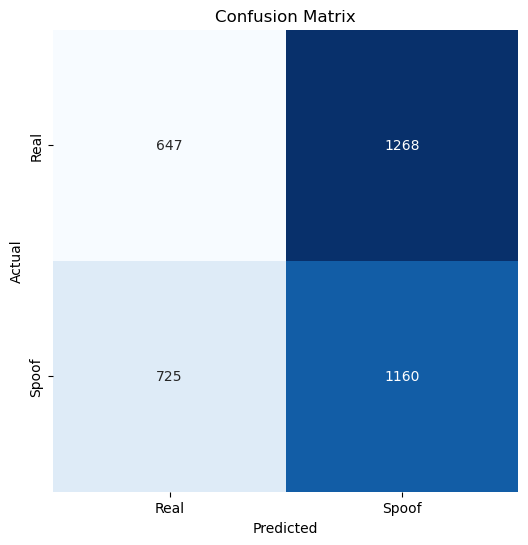

In [36]:
# Plot the confusion matrix for the MSU test results
plot_confusion_matrix(TP=results_nuaa_msu[0]['TP'], TN=results_nuaa_msu[0]['TN'], FP=results_nuaa_msu[0]['FP'], FN=results_nuaa_msu[0]['FN'])

In [37]:
# Load the MobileNet model for the MSU dataset
model_msu, criterion_msu, optimizer_msu = load_mobilenet(LEARNING_RATE, device)

In [38]:
# Train and evaluate the model on the MSU dataset using the training and validation loaders
model_msu, train_losses_msu, val_losses_msu, train_accuracies_msu, val_accuracies_msu = train_and_eval_mobilenet(model_msu, train_loader_msu, val_loader_msu, criterion_msu, optimizer_msu, EPOCHS, device)

Epoch 1/10, Train Loss: 0.0127, Train Accuracy: 99.56%, Val Loss: 0.0001, Val Accuracy: 100.00%
Epoch 2/10, Train Loss: 0.0018, Train Accuracy: 99.95%, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 3/10, Train Loss: 0.0012, Train Accuracy: 99.96%, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 4/10, Train Loss: 0.0001, Train Accuracy: 100.00%, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 5/10, Train Loss: 0.0000, Train Accuracy: 100.00%, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 6/10, Train Loss: 0.0000, Train Accuracy: 100.00%, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 7/10, Train Loss: 0.0000, Train Accuracy: 100.00%, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 8/10, Train Loss: 0.0029, Train Accuracy: 99.92%, Val Loss: 0.0029, Val Accuracy: 99.92%
Epoch 9/10, Train Loss: 0.0004, Train Accuracy: 99.99%, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 10/10, Train Loss: 0.0003, Train Accuracy: 99.99%, Val Loss: 0.0000, Val Accuracy: 100.00%


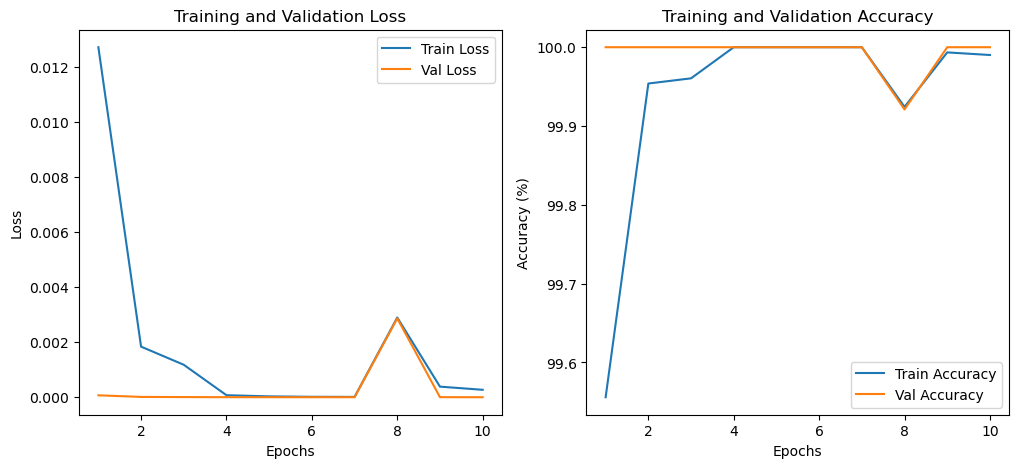

In [39]:
# Plot training curves (losses and accuracies) for the MSU dataset
plot_training_curves(train_losses_msu, val_losses_msu, train_accuracies_msu, val_accuracies_msu)

In [40]:
# Test the model trained on MSU using the unseen test data of MSU
loaded_model_msu, results_msu_msu, TP_msu_msu, TN_msu_msu, FP_msu_msu, FN_msu_msu = test_model(model_msu, test_loader_msu)

APCER: 0.00, BPCER: 0.00, ACER: 0.00
Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-Score: 1.00


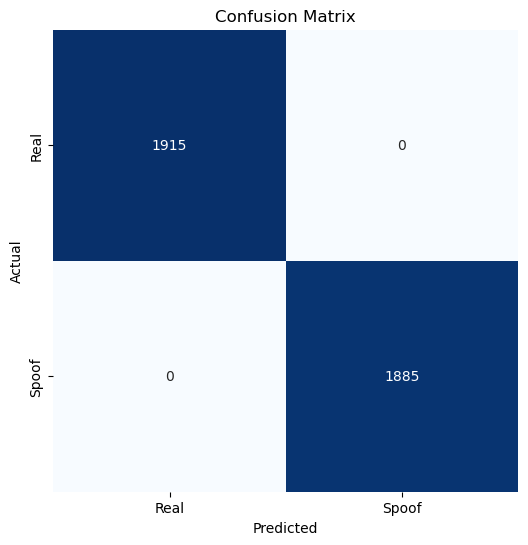

In [41]:
# Plot the confusion matrix for the MSU test results
plot_confusion_matrix(TP=results_msu_msu[0]['TP'], TN=results_msu_msu[0]['TN'], FP=results_msu_msu[0]['FP'], FN=results_msu_msu[0]['FN'])

In [42]:
# Test the model trained on MSU using the test set of NUAA
loaded_model_msu, results_msu_nuaa, TP_msu_nuaa, TN_msu_nuaa, FP_msu_nuaa, FN_msu_nuaa = test_model(model_msu, test_loader_nuaa)

APCER: 0.00, BPCER: 0.88, ACER: 0.44
Accuracy: 0.62, Precision: 1.00, Recall: 0.12, F1-Score: 0.21


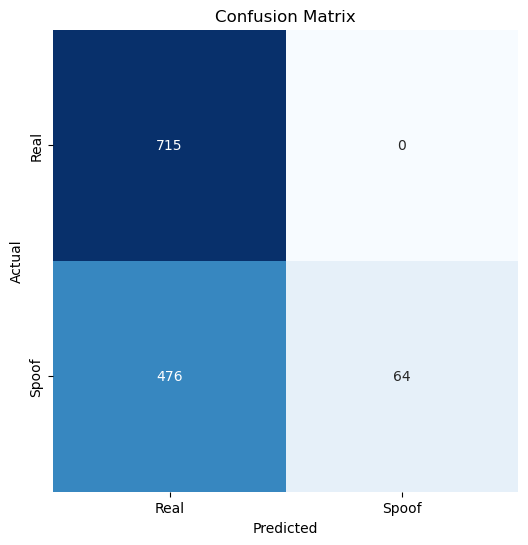

In [43]:
# Plot the confusion matrix for the NUAA test results
plot_confusion_matrix(TP=results_msu_nuaa[0]['TP'], TN=results_msu_nuaa[0]['TN'], FP=results_msu_nuaa[0]['FP'], FN=results_msu_nuaa[0]['FN'])

## LBP Preprocessing + MobileNet Model Training and Evaluation

In [45]:
# Create training and validation datasets with LBP (Local Binary Patterns) preprocessing for the NUAA dataset
train_dataset_nuaa_lbp = ImageDataset(X_train_nuaa, S_train_nuaa, transform=transform, additional_preprocessing='lbp')
val_dataset_nuaa_lbp = ImageDataset(X_val_nuaa, S_val_nuaa, transform=transform, additional_preprocessing='lbp')

In [46]:
# Create training and validation data loaders for the NUAA dataset
train_loader_nuaa_lbp = DataLoader(train_dataset_nuaa_lbp, batch_size=BATCH_SIZE, shuffle=True)
val_loader_nuaa_lbp = DataLoader(val_dataset_nuaa_lbp, batch_size=BATCH_SIZE, shuffle=False)

In [47]:
# Create training and validation datasets with LBP preprocessing for the MSU dataset
train_dataset_msu_lbp = ImageDataset(X_train_msu, S_train_msu, transform=transform, additional_preprocessing='lbp')
val_dataset_msu_lbp = ImageDataset(X_val_msu, S_val_msu, transform=transform, additional_preprocessing='lbp')

In [48]:
# Create training and validation data loaders for the MSU dataset
train_loader_msu_lbp = DataLoader(train_dataset_msu_lbp, batch_size=BATCH_SIZE, shuffle=True)
val_loader_msu_lbp = DataLoader(val_dataset_msu_lbp, batch_size=BATCH_SIZE, shuffle=False)

In [49]:
# Load the MobileNet model for NUAA dataset with LBP
model_nuaa_lbp, criterion_nuaa_lbp, optimizer_nuaa_lbp = load_mobilenet(LEARNING_RATE, device)

In [50]:
summary(model_nuaa_lbp, input_size=(3, 224, 224), verbose=0)

Layer (type:depth-idx)                             Param #
├─Sequential: 1-1                                  --
|    └─Conv2dNormActivation: 2-1                   --
|    |    └─Conv2d: 3-1                            864
|    |    └─BatchNorm2d: 3-2                       64
|    |    └─ReLU6: 3-3                             --
|    └─InvertedResidual: 2-2                       --
|    |    └─Sequential: 3-4                        896
|    └─InvertedResidual: 2-3                       --
|    |    └─Sequential: 3-5                        5,136
|    └─InvertedResidual: 2-4                       --
|    |    └─Sequential: 3-6                        8,832
|    └─InvertedResidual: 2-5                       --
|    |    └─Sequential: 3-7                        10,000
|    └─InvertedResidual: 2-6                       --
|    |    └─Sequential: 3-8                        14,848
|    └─InvertedResidual: 2-7                       --
|    |    └─Sequential: 3-9                        14,848
|  

In [51]:
# Train and evaluate the model on NUAA with LBP using the training and validation loaders
model_nuaa_lbp, train_losses_nuaa_lbp, val_losses_nuaa_lbp, train_accuracies_nuaa_lbp, val_accuracies_nuaa_lbp = train_and_eval_mobilenet(model_nuaa_lbp, train_loader_nuaa_lbp, val_loader_nuaa_lbp, criterion_nuaa_lbp, optimizer_nuaa_lbp, EPOCHS, device)

Epoch 1/10, Train Loss: 0.0400, Train Accuracy: 98.79%, Val Loss: 0.0014, Val Accuracy: 100.00%
Epoch 2/10, Train Loss: 0.0016, Train Accuracy: 99.98%, Val Loss: 0.0007, Val Accuracy: 100.00%
Epoch 3/10, Train Loss: 0.0037, Train Accuracy: 99.90%, Val Loss: 0.0031, Val Accuracy: 99.84%
Epoch 4/10, Train Loss: 0.0024, Train Accuracy: 99.94%, Val Loss: 0.0006, Val Accuracy: 100.00%
Epoch 5/10, Train Loss: 0.0017, Train Accuracy: 99.97%, Val Loss: 0.0005, Val Accuracy: 100.00%
Epoch 6/10, Train Loss: 0.0003, Train Accuracy: 100.00%, Val Loss: 0.0002, Val Accuracy: 100.00%
Epoch 7/10, Train Loss: 0.0001, Train Accuracy: 100.00%, Val Loss: 0.0001, Val Accuracy: 100.00%
Epoch 8/10, Train Loss: 0.0004, Train Accuracy: 99.99%, Val Loss: 0.0033, Val Accuracy: 99.92%
Epoch 9/10, Train Loss: 0.0044, Train Accuracy: 99.86%, Val Loss: 0.0015, Val Accuracy: 99.92%
Epoch 10/10, Train Loss: 0.0022, Train Accuracy: 99.92%, Val Loss: 0.0005, Val Accuracy: 100.00%


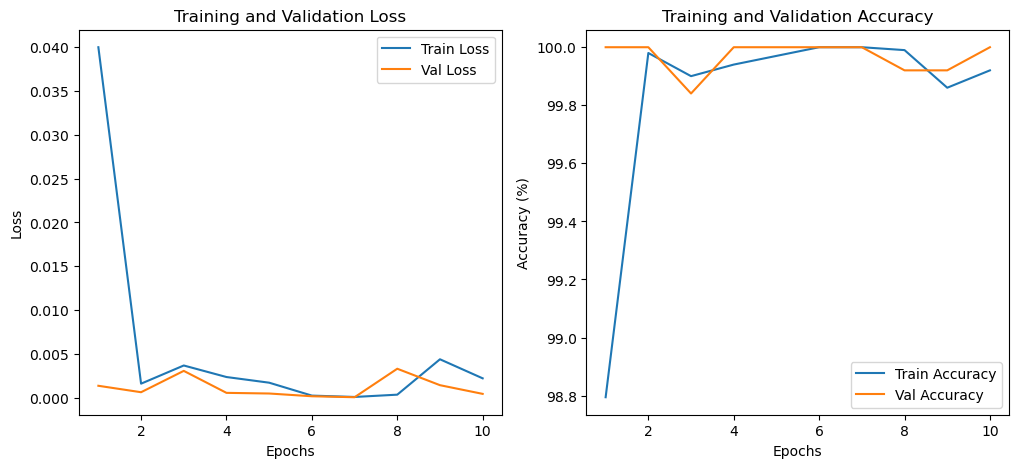

In [52]:
# Plot the training curves for the model trained on NUAA with LBP
plot_training_curves(train_losses_nuaa_lbp, val_losses_nuaa_lbp, train_accuracies_nuaa_lbp, val_accuracies_nuaa_lbp)

In [53]:
# Create a test dataset and loader for NUAA with LBP preprocessing
test_dataset_nuaa_lbp = ImageDataset(X_test_nuaa, S_test_nuaa, transform=transform, additional_preprocessing='lbp')
test_loader_nuaa_lbp = DataLoader(test_dataset_nuaa_lbp, batch_size=BATCH_SIZE, shuffle=False)

In [54]:
# Create a test dataset and loader for MSU with LBP preprocessing
test_dataset_msu_lbp = ImageDataset(X_test_msu, S_test_msu, transform=transform, additional_preprocessing='lbp')
test_loader_msu_lbp = DataLoader(test_dataset_msu_lbp, batch_size=BATCH_SIZE, shuffle=False)

In [55]:
# Test the model trained on NUAA with LBP on the unseen test data of NUAA
loaded_model_nuaa_lbp, results_nuaa_nuaa_lbp, TP_nuaa_nuaa_lbp, TN_nuaa_nuaa_lbp, FP_nuaa_nuaa_lbp, FN_nuaa_nuaa_lbp = test_model(model_nuaa_lbp, test_loader_nuaa_lbp)

APCER: 0.00, BPCER: 0.00, ACER: 0.00
Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-Score: 1.00


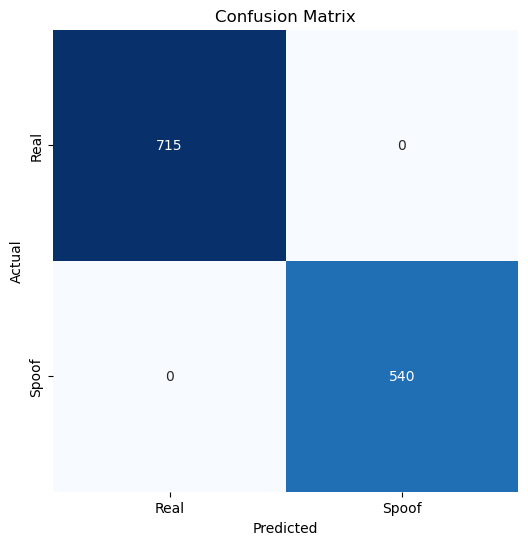

In [56]:
# Plot the confusion matrix for the NUAA test results with LBP
plot_confusion_matrix(TP=results_nuaa_nuaa_lbp[0]['TP'], TN=results_nuaa_nuaa_lbp[0]['TN'], FP=results_nuaa_nuaa_lbp[0]['FP'], FN=results_nuaa_nuaa_lbp[0]['FN'])

In [57]:
# Test the model trained on NUAA with LBP on the MSU test set
loaded_model_nuaa_lbp, results_nuaa_msu_lbp, TP_nuaa_msu_lbp, TN_nuaa_msu_lbp, FP_nuaa_msu_lbp, FN_nuaa_msu_lbp = test_model(model_nuaa_lbp, test_loader_msu_lbp)

APCER: 0.24, BPCER: 0.52, ACER: 0.38
Accuracy: 0.62, Precision: 0.67, Recall: 0.48, F1-Score: 0.56


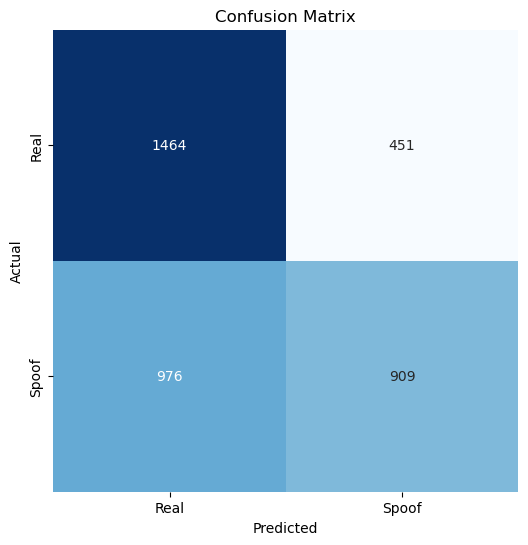

In [58]:
# Plot the confusion matrix for the MSU test results with LBP
plot_confusion_matrix(TP=results_nuaa_msu_lbp[0]['TP'], TN=results_nuaa_msu_lbp[0]['TN'], FP=results_nuaa_msu_lbp[0]['FP'], FN=results_nuaa_msu_lbp[0]['FN'])

In [59]:
# Load the MobileNet model for MSU dataset with LBP
model_msu_lbp, criterion_msu_lbp, optimizer_msu_lbp = load_mobilenet(LEARNING_RATE, device)

In [60]:
# Train and evaluate the model on MSU with LBP using the training and validation loaders
model_msu_lbp, train_losses_msu_lbp, val_losses_msu_lbp, train_accuracies_msu_lbp, val_accuracies_msu_lbp = train_and_eval_mobilenet(model_msu_lbp, train_loader_msu_lbp, val_loader_msu_lbp, criterion_msu_lbp, optimizer_msu_lbp, EPOCHS, device)

Epoch 1/10, Train Loss: 0.0251, Train Accuracy: 99.09%, Val Loss: 0.0003, Val Accuracy: 100.00%
Epoch 2/10, Train Loss: 0.0019, Train Accuracy: 99.95%, Val Loss: 0.0001, Val Accuracy: 100.00%
Epoch 3/10, Train Loss: 0.0027, Train Accuracy: 99.92%, Val Loss: 0.0001, Val Accuracy: 100.00%
Epoch 4/10, Train Loss: 0.0002, Train Accuracy: 100.00%, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 5/10, Train Loss: 0.0019, Train Accuracy: 99.95%, Val Loss: 0.0001, Val Accuracy: 100.00%
Epoch 6/10, Train Loss: 0.0023, Train Accuracy: 99.92%, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 7/10, Train Loss: 0.0001, Train Accuracy: 100.00%, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 8/10, Train Loss: 0.0004, Train Accuracy: 99.99%, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 9/10, Train Loss: 0.0044, Train Accuracy: 99.89%, Val Loss: 0.0000, Val Accuracy: 100.00%
Epoch 10/10, Train Loss: 0.0014, Train Accuracy: 99.97%, Val Loss: 0.0000, Val Accuracy: 100.00%


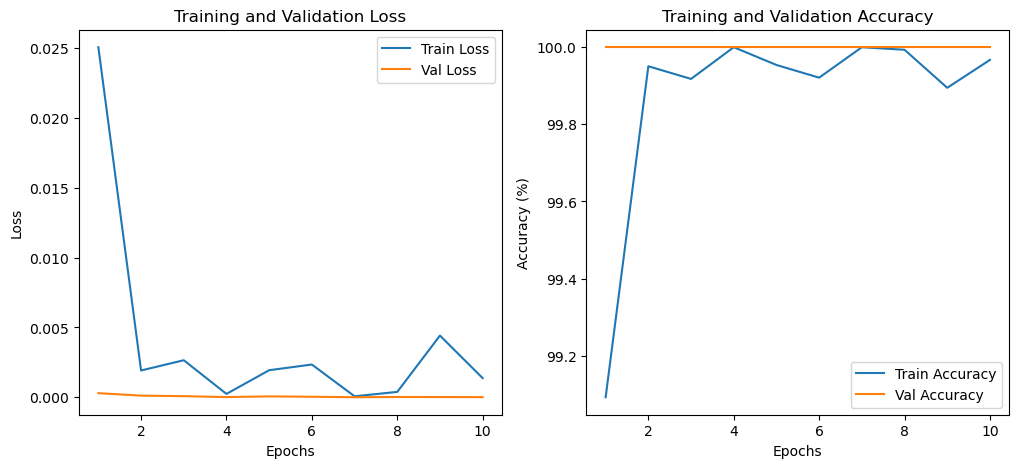

In [61]:
# Plot training curves for the MSU model with LBP
plot_training_curves(train_losses_msu_lbp, val_losses_msu_lbp, train_accuracies_msu_lbp, val_accuracies_msu_lbp)

In [62]:
# Test the model trained on MSU with LBP on the unseen test data of MSU
loaded_model_msu_lbp, results_msu_msu_lbp, TP_msu_msu_lbp, TN_msu_msu_lbp, FP_msu_msu_lbp, FN_msu_msu_lbp = test_model(model_msu_lbp, test_loader_msu_lbp)

APCER: 0.00, BPCER: 0.00, ACER: 0.00
Accuracy: 1.00, Precision: 1.00, Recall: 1.00, F1-Score: 1.00


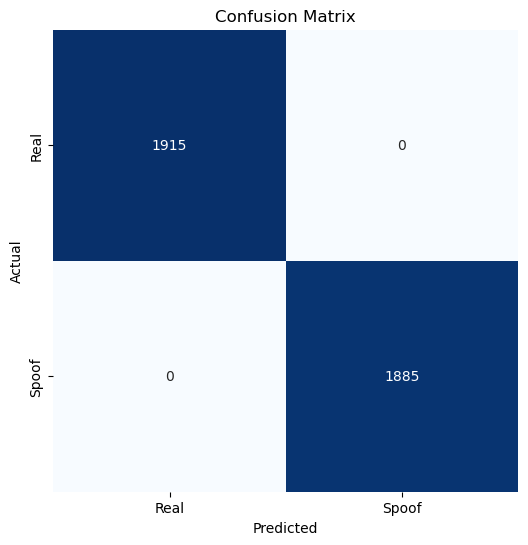

In [63]:
# Plot the confusion matrix for the MSU test results with LBP
plot_confusion_matrix(TP=results_msu_msu_lbp[0]['TP'], TN=results_msu_msu_lbp[0]['TN'], FP=results_msu_msu_lbp[0]['FP'], FN=results_msu_msu_lbp[0]['FN'])

In [64]:
# Test the model trained on MSU with LBP on the NUAA test set
loaded_model_msu_lbp, results_msu_nuaa_lbp, TP_msu_nuaa_lbp, TN_msu_nuaa_lbp, FP_msu_nuaa_lbp, FN_msu_nuaa_lbp = test_model(model_msu_lbp, test_loader_nuaa_lbp)

APCER: 0.02, BPCER: 0.94, ACER: 0.48
Accuracy: 0.58, Precision: 0.67, Recall: 0.06, F1-Score: 0.11


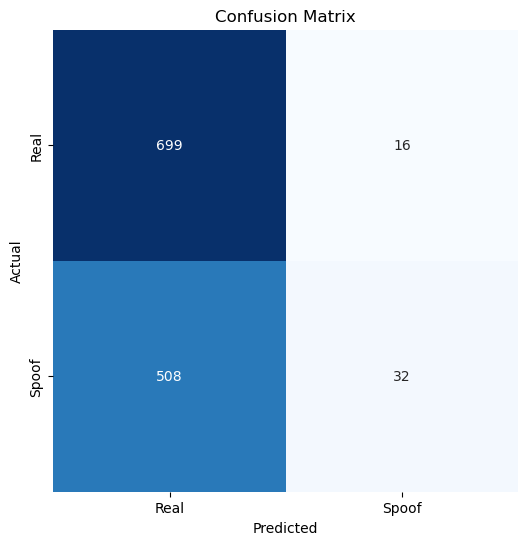

In [65]:
# Plot the confusion matrix for the NUAA test results with LBP
plot_confusion_matrix(TP=results_msu_nuaa_lbp[0]['TP'], TN=results_msu_nuaa_lbp[0]['TN'], FP=results_msu_nuaa_lbp[0]['FP'], FN=results_msu_nuaa_lbp[0]['FN'])

In [66]:
save_model(model_nuaa, "mobilenet_v2_nuaa_model.pth")
save_model(model_msu, "mobilenet_v2_msu_model.pth")
save_model(model_nuaa_lbp, "mobilenet_v2_lbp_nuaa_model.pth")
save_model(model_msu_lbp, "mobilenet_v2_lbp_msu_model.pth")